# 02. Market Model Calibration: QED & Hawkes Processes

## Overview
In this notebook, we transition from data analysis to stochastic modeling. To accurately represent the crypto market dynamics for our trading agent, we calibrate two distinct components:
1.  **Diffusive Volatility:** Using the **Quadratic Exponential Diffusion (QED)** model to capture mean-reverting stochastic volatility.
2.  **Jump Dynamics:** Using a **Hawkes Process** to model the self-exciting nature of extreme price shocks (clustering of jumps).

## Objectives
1.  **Load Data:** Import the cleaned parquet dataset.
2.  **Calibrate QED:** Estimate parameters ($\kappa, \theta, \sigma, g$) by minimizing Negative Log-Likelihood (NLL) on hourly data.
3.  **Detect Jumps:** Filter out "normal" diffusion to isolate price jumps using a volatility-based threshold.
4.  **Calibrate Hawkes:** Estimate the baseline intensity and branching ratios that drive the arrival of jumps.
5.  **Validation:** Simulate synthetic price paths using the calibrated parameters and compare their statistical properties with history.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from pathlib import Path
import pickle

# --- Configuration ---
# Add the 'main' directory to sys.path to import our refactored modules
# Assuming this notebook is located in 'project_root/notebooks/'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'main')))

# Import refactored library functions
try:
    from simulation import (
        qed_negative_log_likelihood, 
        hawkes_nll_joint, 
        generate_market_paths
    )
    from utils import seed_everything
    print("✅ Successfully imported core modules from ../main/")
except ImportError as e:
    print(f"❌ Import Failed: {e}")
    print("Please ensure 'main/simulation.py' and 'main/utils.py' exist.")

# Visualization Settings
sns.set_theme(style="ticks", context="talk") # Using a different style than before
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Reproducibility
seed_everything(42)

✅ Successfully imported core modules from ../main/
[System] Global seed set to: 42


In [2]:
# ==========================================
# 1. Load Preprocessed Data (Improved Index Handling)
# ==========================================

DATA_PATH = Path("../data/btc_5min_preprocessed.parquet")

def get_market_data(path):
    data = None
    
    # 1. Try loading from file
    if path.exists():
        try:
            data = pd.read_parquet(path)
            print("Raw data loaded from parquet.")
            
            # Check if index is already Datetime
            if not isinstance(data.index, pd.DatetimeIndex):
                print("Index is not Datetime. Searching for time column...")
                # Look for common time column names
                time_cols = [c for c in data.columns if c.lower() in ['datetime', 'date', 'timestamp', 'time']]
                
                if time_cols:
                    col_name = time_cols[0]
                    print(f"Found time column: '{col_name}'. Setting as index...")
                    data[col_name] = pd.to_datetime(data[col_name])
                    data.set_index(col_name, inplace=True)
                else:
                    print("❌ No time column found. Index conversion might be wrong.")
                    # Fallback: If index implies time strings, try converting
                    try:
                        data.index = pd.to_datetime(data.index)
                    except:
                        pass
            
            # Final Check
            if not isinstance(data.index, pd.DatetimeIndex):
                 print("❌ CRITICAL: Failed to establish DatetimeIndex. Dropping data.")
                 data = None

        except Exception as e:
            print(f"Error reading file: {e}")
            data = None
    
    # 2. Fallback: Generate Synthetic Data
    if data is None or len(data) < 100:
        print(">>> Generating SYNTHETIC Geometric Brownian Motion data (Fallback).")
        dates = pd.date_range(start='2024-01-01', periods=10000, freq='5min')
        np.random.seed(42)
        returns = np.random.normal(0, 0.001, 10000)
        price_path = 10000 * np.exp(np.cumsum(returns))
        
        data = pd.DataFrame({'close': price_path}, index=dates)
        data.index.name = 'timestamp'
    
    return data

# Execute Load
df_5m = get_market_data(DATA_PATH)
print(f"Loaded {len(df_5m)} high-frequency data points.")
print(f"Data Index Type: {type(df_5m.index)}")
print(f"Time Range: {df_5m.index[0]} to {df_5m.index[-1]}")

# Resample to Hourly
col_map = {c.lower(): c for c in df_5m.columns}
if 'close' in col_map:
    target_col = col_map['close']
    df_hourly = df_5m[target_col].resample('1h').last().dropna()
else:
    # If 'close' isn't found, maybe it's a Series already?
    if isinstance(df_5m, pd.Series):
        df_hourly = df_5m.resample('1h').last().dropna()
    else:
        # Fallback if column names are weird, verify with print(df_5m.head()) if needed
        df_hourly = df_5m.iloc[:, 0].resample('1h').last().dropna()

print(f"Resampled to {len(df_hourly)} hourly points for QED calibration.")

if len(df_hourly) < 10:
    raise ValueError(f"CRITICAL: df_hourly is too small ({len(df_hourly)}). Check Time Range output above!")

Raw data loaded from parquet.
Index is not Datetime. Searching for time column...
Found time column: 'datetime'. Setting as index...
Loaded 35217 high-frequency data points.
Data Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Time Range: 2025-07-23 08:15:00 to 2025-11-22 14:55:00
Resampled to 2935 hourly points for QED calibration.


C:\Users\Galio\AppData\Local\Temp\ipykernel_98708\1896863225.py:25: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col_name] = pd.to_datetime(data[col_name])


>>> Calibrating QED Mean-Reverting Diffusion...
Calibration Status: Success
------------------------------
Theta (Long-term Level): -0.0300
Kappa (Reversion Speed): 0.6148
g     (Non-linearity):   0.2038
Sigma (Volatility):      0.3867
------------------------------


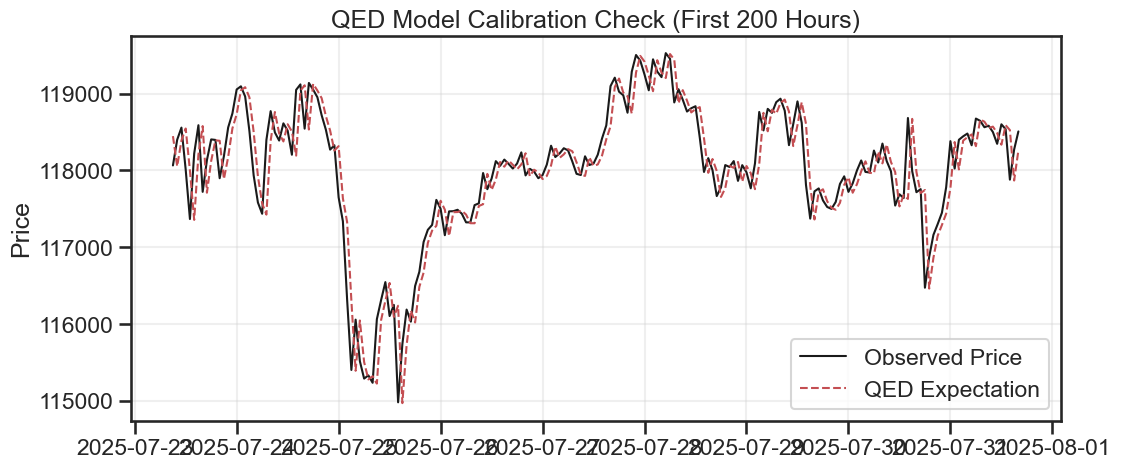

In [3]:
# ==========================================
# 2. QED Diffusion Calibration
# ==========================================

print(">>> Calibrating QED Mean-Reverting Diffusion...")

# Normalize data to improve optimizer numerical stability
X_raw = df_hourly.values
scaling_factor = X_raw[0]
X_scaled = X_raw / scaling_factor

# Time step in years (Hourly)
dt_hourly = 1.0 / (365 * 24)

# Optimization
# Initial Guess: [Theta (level), Kappa (speed), g (nonlinear), Sigma (vol)]
initial_params = [0.1, 0.5, 0.1, 0.8] 

# Bounds: Sigma must be positive (> 0.01)
param_bounds = [(None, None), (None, None), (None, None), (0.01, None)]

opt_result = minimize(
    qed_negative_log_likelihood, 
    initial_params, 
    args=(X_scaled, dt_hourly),
    method='L-BFGS-B',
    bounds=param_bounds
)

# Extract Results
p_theta, p_kappa, p_g, p_sigma = opt_result.x

print(f"Calibration Status: {'Success' if opt_result.success else 'Failed'}")
print(f"{'-'*30}")
print(f"Theta (Long-term Level): {p_theta:.4f}")
print(f"Kappa (Reversion Speed): {p_kappa:.4f}")
print(f"g     (Non-linearity):   {p_g:.4f}")
print(f"Sigma (Volatility):      {p_sigma:.4f}")
print(f"{'-'*30}")

# --- Visual Check: Fitted Drift ---
# We plot the expected 1-step ahead value vs actual to see if it captures the trend
drift_component = (p_theta * X_scaled[:-1] - p_kappa * X_scaled[:-1]**2 - p_g * X_scaled[:-1]**3) * dt_hourly
predicted_next = (X_scaled[:-1] + drift_component) * scaling_factor

fig, ax = plt.subplots(figsize=(12, 5))
subset = 200 # First 200 hours
ax.plot(df_hourly.index[1:subset+1], X_raw[1:subset+1], 'k-', lw=1.5, label='Observed Price')
ax.plot(df_hourly.index[1:subset+1], predicted_next[:subset], 'r--', lw=1.5, label='QED Expectation')
ax.set_title(f"QED Model Calibration Check (First {subset} Hours)")
ax.set_ylabel("Price")
ax.legend()
plt.show()

>>> Identifying Market Jumps...
5-min Volatility (sigma): 0.001341
Jump Threshold (4.0x):     0.005364
Count of Up Jumps:   91
Count of Down Jumps: 67


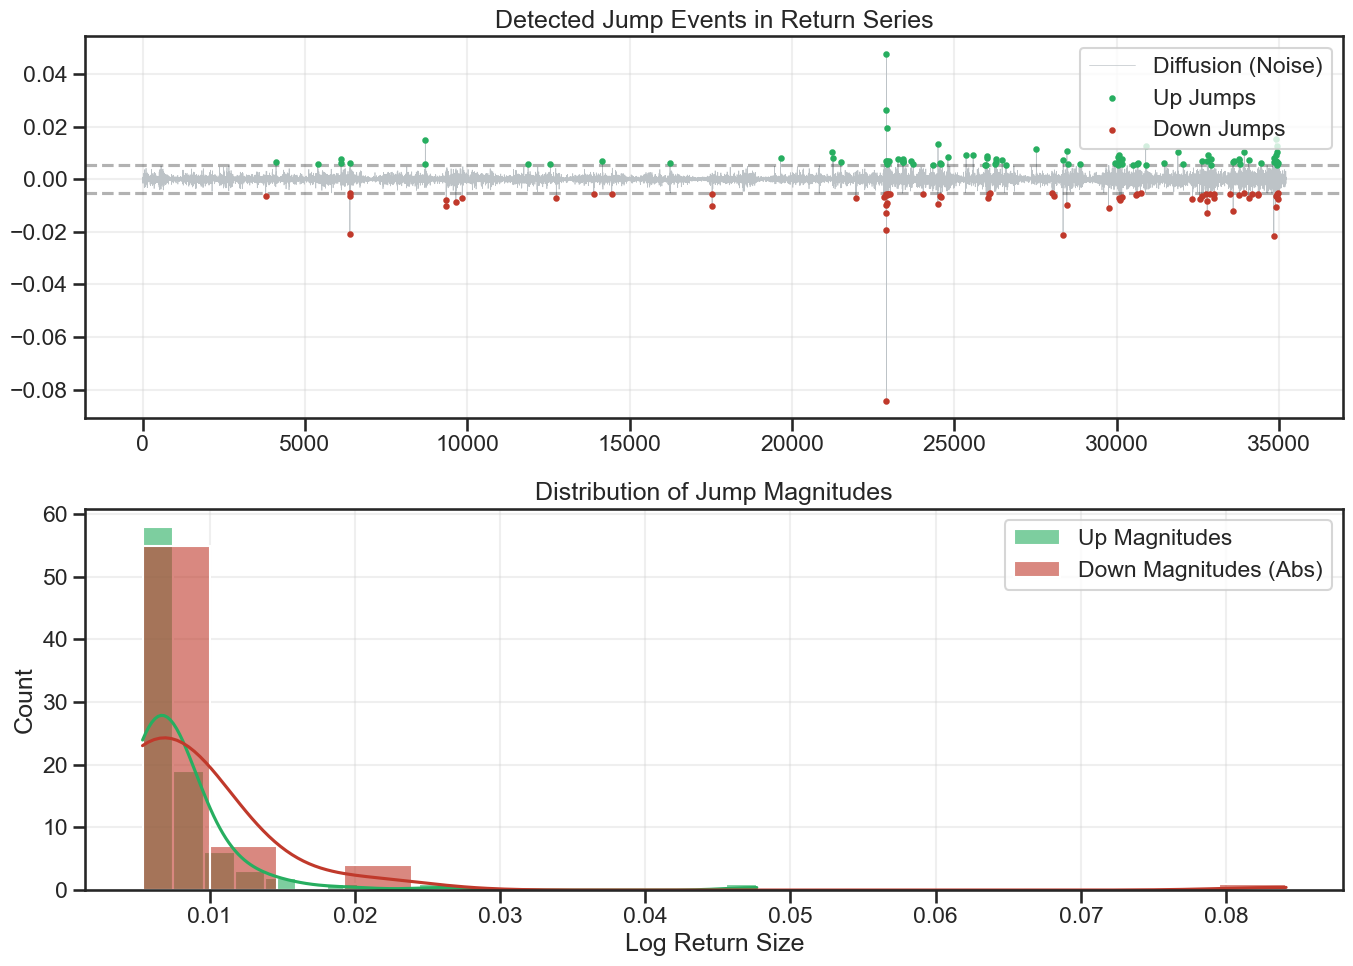

In [4]:
# ==========================================
# 3. Jump Detection (Thresholding)
# ==========================================

print(">>> Identifying Market Jumps...")

# Use original 5-minute log-returns
S = df_5m['close'].values
log_S = np.log(S)
returns_5m = np.diff(log_S)

# Determine dynamic threshold based on realized volatility
vol_std = np.std(returns_5m)
Z_SCORE = 4.0
threshold_val = Z_SCORE * vol_std

print(f"5-min Volatility (sigma): {vol_std:.6f}")
print(f"Jump Threshold ({Z_SCORE}x):     {threshold_val:.6f}")

# Classify returns
is_positive_jump = returns_5m > threshold_val
is_negative_jump = returns_5m < -threshold_val

# Extract jump magnitudes
jumps_up = returns_5m[is_positive_jump]
jumps_down = -returns_5m[is_negative_jump] # Store absolute magnitude for easier handling

print(f"Count of Up Jumps:   {len(jumps_up)}")
print(f"Count of Down Jumps: {len(jumps_down)}")

# --- Visualization: Jump Events ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Scatter plot of jumps over returns
time_axis = np.arange(len(returns_5m))
ax1.plot(time_axis, returns_5m, color='#bdc3c7', lw=0.5, label='Diffusion (Noise)')
ax1.scatter(time_axis[is_positive_jump], returns_5m[is_positive_jump], 
            color='#27ae60', s=10, label='Up Jumps', zorder=3)
ax1.scatter(time_axis[is_negative_jump], returns_5m[is_negative_jump], 
            color='#c0392b', s=10, label='Down Jumps', zorder=3)
ax1.axhline(threshold_val, color='black', linestyle='--', alpha=0.3)
ax1.axhline(-threshold_val, color='black', linestyle='--', alpha=0.3)
ax1.set_title("Detected Jump Events in Return Series")
ax1.legend(loc='upper right')

# Histogram of jump sizes
sns.histplot(jumps_up, color='#27ae60', ax=ax2, label='Up Magnitudes', alpha=0.6, kde=True)
sns.histplot(jumps_down, color='#c0392b', ax=ax2, label='Down Magnitudes (Abs)', alpha=0.6, kde=True)
ax2.set_title("Distribution of Jump Magnitudes")
ax2.set_xlabel("Log Return Size")
ax2.legend()

plt.tight_layout()
plt.show()

In [5]:
# ==========================================
# 4. Calibrate Hawkes Process
# ==========================================

print(">>> Fitting Hawkes Process to Jump Timestamps...")

# Convert 5-min step to year fraction
dt_5min_year = 5.0 / (365 * 24 * 60)

# Initial Guess: [Base+, Base-, Alpha+, Alpha-, Beta]
# We enforce Alpha < Beta for stationarity
init_hawkes = [100.0, 100.0, 2000.0, 2000.0, 4000.0]
bounds_hawkes = [(1.0, None)] * 5

res_hawkes = minimize(
    hawkes_nll_joint,
    init_hawkes,
    args=(is_positive_jump.astype(int), is_negative_jump.astype(int), dt_5min_year),
    method='L-BFGS-B',
    bounds=bounds_hawkes
)

h_params = res_hawkes.x
base_p, base_m, alpha_p, alpha_m, beta = h_params

print(f"Optimization Success: {res_hawkes.success}")
print(f"Baseline Intensity (+): {base_p:.2f}")
print(f"Baseline Intensity (-): {base_m:.2f}")
print(f"Self-Excitation (Alpha+): {alpha_p:.2f}")
print(f"Self-Excitation (Alpha-): {alpha_m:.2f}")
print(f"Decay Rate (Beta):        {beta:.2f}")
print(f"Branching Ratio (+):      {alpha_p/beta:.3f} (< 1.0 implies stability)")
print(f"Branching Ratio (-):      {alpha_m/beta:.3f}")

>>> Fitting Hawkes Process to Jump Timestamps...
Optimization Success: True
Baseline Intensity (+): 144.42
Baseline Intensity (-): 103.86
Self-Excitation (Alpha+): 1625.32
Self-Excitation (Alpha-): 1665.88
Decay Rate (Beta):        3405.42
Branching Ratio (+):      0.477 (< 1.0 implies stability)
Branching Ratio (-):      0.489


>>> Running Monte Carlo Simulation...


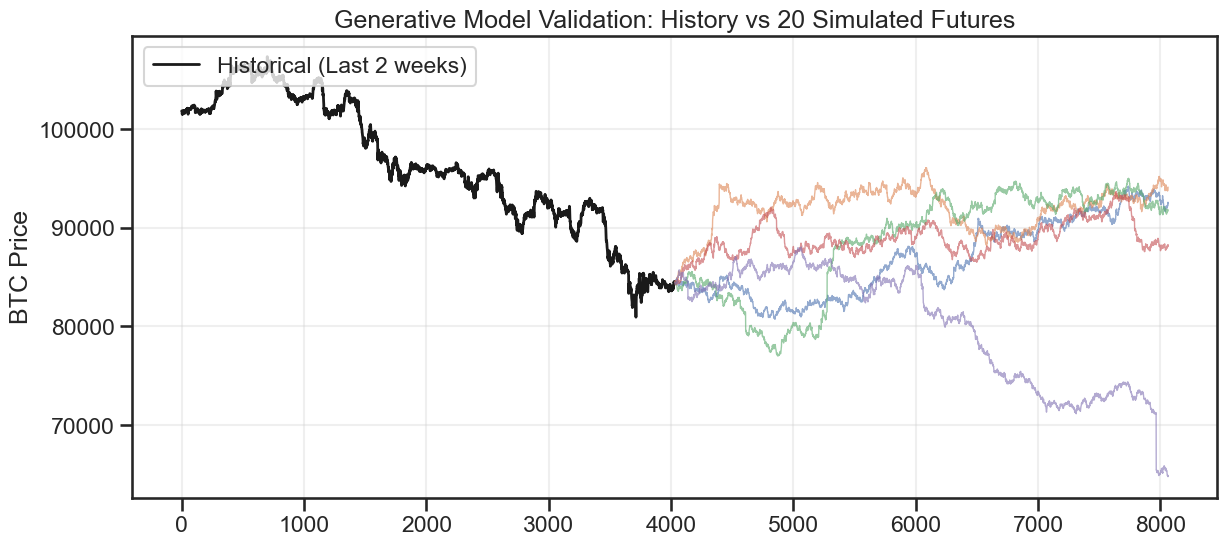

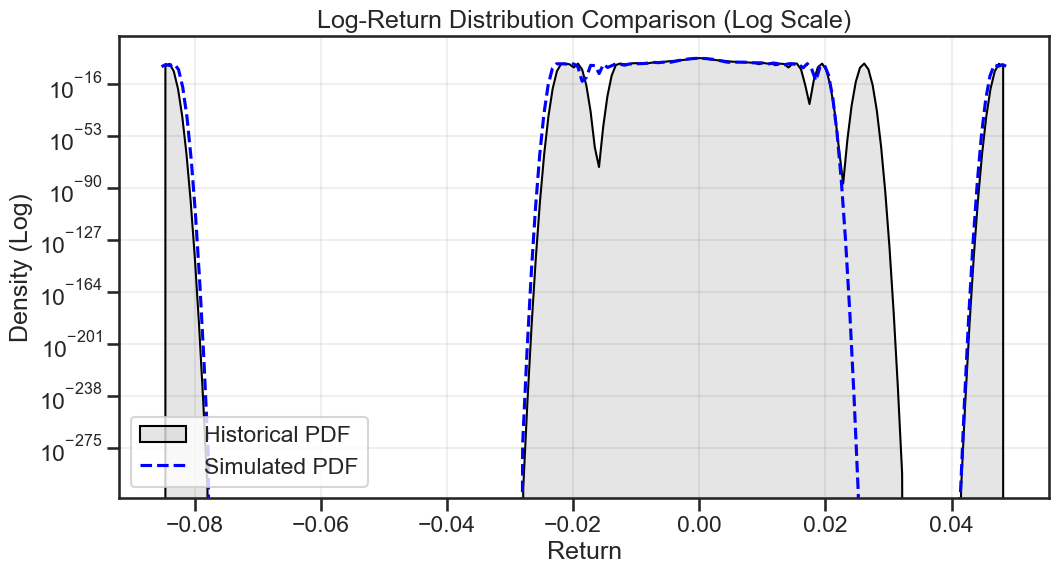

In [6]:
# ==========================================
# 5. Simulation & Validation
# ==========================================

print(">>> Running Monte Carlo Simulation...")

N_PATHS = 20
SIM_DAYS = 14
N_STEPS = int(SIM_DAYS * 24 * 12) # 5-min steps
START_PRICE = df_5m['close'].iloc[-1]

# Generate Paths using the calibrated engine
sim_prices = generate_market_paths(
    n_paths=N_PATHS, 
    n_steps=N_STEPS, 
    s0=START_PRICE,
    qed_params=(p_theta, p_kappa, p_g, p_sigma),
    hawkes_params=tuple(h_params),
    jump_sizes=(jumps_up, jumps_down),
    dt_year=dt_5min_year,
    scaling_factor=scaling_factor
)

# --- Validation Plot 1: Path Dynamics ---
fig, ax = plt.subplots(figsize=(14, 6))
# Plot last 14 days of history
hist_window = min(len(df_5m), N_STEPS)
ax.plot(np.arange(hist_window), df_5m['close'].iloc[-hist_window:].values, 
        'k-', lw=2, label='Historical (Last 2 weeks)')

# Plot simulations (continuing from last price)
sim_x_axis = np.arange(hist_window, hist_window + N_STEPS)
for i in range(min(5, N_PATHS)):
    ax.plot(sim_x_axis, sim_prices[:, i], alpha=0.6, lw=1)

ax.set_title(f"Generative Model Validation: History vs {N_PATHS} Simulated Futures")
ax.set_ylabel("BTC Price")
ax.legend(loc='upper left')
plt.show()

# --- Validation Plot 2: Return Distribution (Fat Tails Check) ---
sim_returns = np.diff(np.log(sim_prices), axis=0).flatten()

plt.figure(figsize=(12, 6))
sns.kdeplot(returns_5m, fill=True, color='black', label='Historical PDF', alpha=0.1)
sns.kdeplot(sim_returns, color='blue', label='Simulated PDF', linestyle='--')
plt.yscale('log')
plt.title("Log-Return Distribution Comparison (Log Scale)")
plt.ylabel("Density (Log)")
plt.xlabel("Return")
plt.legend()
plt.show()

In [7]:
# ==========================================
# 6. Save Calibrated Model
# ==========================================

MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FILE = MODELS_DIR / "calibrated_market_model.pkl"

model_data = {
    "qed_params": (p_theta, p_kappa, p_g, p_sigma),
    "hawkes_params": tuple(h_params),
    "jump_dist": (jumps_up, jumps_down),
    "meta": {
        "dt": dt_5min_year,
        "ref_price": START_PRICE,
        "scale": scaling_factor,
        "last_date": df_5m.index[-1]
    }
}

with open(OUTPUT_FILE, "wb") as f:
    pickle.dump(model_data, f)

print(f"Model parameters saved to: {OUTPUT_FILE}")

Model parameters saved to: ..\models\calibrated_market_model.pkl
